In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import pymalts as pm
import networkx as nx
import sklearn.linear_model as lm
import sklearn.tree as tree
import sklearn.svm as svm
import sklearn.ensemble as en
import warnings
warnings.filterwarnings("ignore")

path_to_git = '/Users/harshparikh/Documents/GitHub/iic_causal_inference/'

iic_burden = pd.read_pickle(path_to_git + 'aim1/data_to_fit_CNNIIC_iic_burden_smooth.pickle')

sns.set(font_scale=3,style='whitegrid')

In [10]:
iic_burden.keys()

dict_keys(['W', 'window_start_ids', 'D', 'Ddose', 'Dname', 'Pobs', 'Pname', 'C', 'Cname', 'Y', 'Yname', 'cluster', 'sids', 'pseudoMRNs'])

In [11]:
def plot_unit(E,D,Dnames):
    n_drugs = D.shape[1]
    drug_names = Dnames
    fig,axs = plt.subplots(nrows=1+D.shape[1],ncols=1,
                           sharex=True,
                           figsize=(15, 6 + 1.25*n_drugs),
                           gridspec_kw = {'height_ratios':[4]+[1 for i in range(D.shape[1])]})
    axs[0].plot( E, c='black',label='Observed')
    axs[0].set_title('IIC Burden')
    for i in range(1,1+n_drugs):
        y = D[:,i-1]
        axs[i].imshow(y[np.newaxis,:], cmap="copper", aspect="auto")
        axs[i].set_title(drug_names[i-1])
    

def setup_data(iic_burden,frame=10):
    df = pd.DataFrame(iic_burden['C'],columns=iic_burden['Cname'],index=iic_burden['sids'])
    df['mRS'] = iic_burden['Y']
    n = df.shape[0]
    df_wave = pd.DataFrame()
    for i in (range(n)):
        try:
            E = iic_burden['Pobs'][i][:frame]
            Ename = ['iic_%d'%(j) for j in range(frame)]
            D = iic_burden['D'][i][:frame,:]
            time_of_intervention = np.argmax(D.sum(axis=1)>0)
            if D.sum(axis=1)[time_of_intervention] == 0:
                time_of_intervention = frame-1
            D_flat = D.reshape(-1,)
            Dname_flat = np.array([ ['%s_%d'%(drug,j) for drug in iic_burden['Dname'] ] for j in range(frame) ]).reshape(-1,)
            D_summary = D.sum(axis=0)
            First_D = iic_burden['Dname'][np.argmax(D[time_of_intervention,:])]
            Dname_summary = iic_burden['Dname']
            E_summary_pre = np.nanmean(E[:time_of_intervention])
            E_summary_post = np.nanmean(E[time_of_intervention:])
            if D.sum(axis=1)[time_of_intervention] == 0:
                time_of_intervention = np.inf
                First_D = 0
                E_summary_post = E_summary_pre
            df_temp = pd.DataFrame( [[time_of_intervention]+[First_D]+list(E)+[E_summary_pre,E_summary_post]+list(D_flat)+list(D_summary)], 
                                   index = [df.index[i]],
                                   columns = ['time_of_intervention']+['drug_administered']+Ename+['avg_iic_pre','avg_iic_post']+list(Dname_flat)+list(Dname_summary))
    #         print(df.index[i],df_temp)
            df_wave = df_wave.append(df_temp)
        except:
            continue
    df = df.join(df_wave)
    return df

def setup_coarsen_data(iic_burden,window = 36,summarize='max',**kwargs):
    df = pd.DataFrame(iic_burden['C'],columns=iic_burden['Cname'],index=iic_burden['sids'])
    df['mRS'] = iic_burden['Y']
    n = df.shape[0]
    E_col = []
    D_col = []
    for i in (range(n)):
        t = len(iic_burden['Pobs'][i])
        if t>window:
            if summarize == 'max':
                E = np.max([ np.nanmean(iic_burden['Pobs'][i][j:j+window]) for j in range(t-window) ])
            if summarize == 'proportion':
                threshold = kwargs.get('threshold',0.5)
                E = np.nanmean( np.array([ np.nanmean(iic_burden['Pobs'][i][j:j+window]) for j in range(t-window) ]) > threshold )
            if summarize == 'mean':
                E = np.mean([ np.nanmean(iic_burden['Pobs'][i][j:j+window]) for j in range(t-window) ])
        else:
            E = np.nanmean(iic_burden['Pobs'][i])
        E_col.append(E)
        D = np.nanmean(iic_burden['D'][i],axis=0)
        D_col.append(D)
    df['E'] = E_col
    df_D = pd.DataFrame(D_col,columns=iic_burden['Dname'],index=df.index)
    df = df.join(df_D,how='inner')
    return df

# Bias in CNN (DenseNet)




$E_{true} = E_{obs} - CNN_{bias}$

In [12]:
df_pkpd = pd.read_csv('PD_Parameters_result.csv',index_col=0)
df_pkpd = df_pkpd.fillna(df_pkpd.mean())

In [13]:
df_coarsen = setup_coarsen_data( iic_burden, window = 6, summarize = 'max')

df_coarsen_1 = df_coarsen[iic_burden['Cname']+['mRS', 'E'
                                               ,'lacosamide', 'levetiracetam', 'midazolam', 
                                               'pentobarbital', 'phenobarbital', 'propofol', 'valproate']].dropna()

df_coarsen_1 = df_coarsen_1.join(df_pkpd,how='inner')

df_race = pd.read_csv('covariates-full.csv',index_col=0)[['Race']]
df_race = df_race.loc[list(df_coarsen_1.index)]
df_race = pd.get_dummies(df_race)[['Race_Asian', 'Race_Black or African American', 'Race_White or Caucasian']]
df_coarsen_1 = df_coarsen_1.join(df_race,how='inner')

continuous = ['Age','iGCS-Total','iGCS = T?','Worst GCS in 1st 24h','Worst GCS intub','APACHE II 1st 24h',
              'SBP highest (1st 24h)','SBP lowest (1st 24h)','DBP highest (1st 24h)','DBP lowest (1st 24h)',
              'HR highest (1std 24h)','HR lowest (1st 24h)','premorbid MRS']
discrete = set(iic_burden['Cname']).difference(continuous)
discrete = list(discrete) + ['Race_Asian', 'Race_Black or African American', 'Race_White or Caucasian']

df_coarsen_1['Y'] = (df_coarsen_1['mRS'] > 3).astype(float)

n_thresholds = 5
thresholds = [0,0.25,0.5,0.75,1] #list(np.linspace(0,1,num=n_thresholds))
gain = thresholds[1]-thresholds[0]



In [15]:
apo_tight_0_c_pkpd_sens = pd.DataFrame()

for mispred in np.linspace(start=-0.2, stop=0.2, num=10):
    iic_obs = (df_coarsen_1['E'] - mispred)
    iic_obs = iic_obs * (iic_obs > 0)
    iic_obs = iic_obs * (iic_obs <= 1) + (iic_obs > 1)
    
    iic_level = df_coarsen_1['E']>2
    for threshold in thresholds:
        iic_level = iic_level + gain*(iic_obs>threshold).astype(int)

    iic_level = iic_level - (gain/2) * ((iic_level - (gain/2)) > 0)
    
    drug_level = ( (df_coarsen_1['levetiracetam'] > 20) + 
                  (df_coarsen_1['propofol']>1) + 
                  (df_coarsen_1['midazolam']>0) +
                  (df_coarsen_1['lacosamide']>0) +
                  (df_coarsen_1['pentobarbital']>0) +
                  (df_coarsen_1['phenobarbital']>0) +
                  (df_coarsen_1['valproate']>0) ).astype(int)

    df_coarsen_1['iic'] = np.round(iic_level,2).astype(str)
    df_coarsen_1['drug'] = drug_level
    df_coarsen_1['T'] = '(' + df_coarsen_1['iic'].astype(str) + ', ' + df_coarsen_1['drug'].astype(str) + ')'
    
    n_repeats = 5
    n_splits = 3
    df_malts_data = df_coarsen_1[iic_burden['Cname']+list(df_pkpd.columns)+['Y','T']]
    discrete = list(set(iic_burden['Cname']).difference(continuous))
    m = pm.malts_mf(outcome='Y',
                    treatment='T', 
                    data=df_malts_data,
                    n_repeats=n_repeats,
                    n_splits=n_splits,
                    output_format='full',
                    k_tr=3,
                    k_est=5,
                    discrete = discrete,
                    C=0.01)
    
    out = m.CATE_df.drop(columns = ['Y','T'])#.T.groupby(level=0).mean().T
    
    columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1) 
               if 'Y(('+str(np.round(threshold-gain/2,2))+', 0))' in out.columns ]
    apo_0_c_pkpd = out[columns]
    
    columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1) 
               if 'Y(('+str(np.round(threshold-gain/2,2))+', 0))' in out.columns ]
    diam_0_c_pkpd = out[columns]

    apo_tight_0_c_pkpd = pd.DataFrame(apo_0_c_pkpd.values*(diam_0_c_pkpd<2000).astype(int).replace(0, np.nan).values,
                             index=apo_0_c_pkpd.index,columns=apo_0_c_pkpd.columns)
    apo_tight_0_c_pkpd.mean(axis=0)

    pd_temp = apo_tight_0_c_pkpd.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'})
    pd_temp['Sensitivity Parameter'] = np.ones((pd_temp.shape[0],)) * mispred
    
    apo_tight_0_c_pkpd_sens = apo_tight_0_c_pkpd_sens.append(pd_temp,ignore_index=True)

In [16]:
apo_tight_0_c_pkpd_sens['index'].unique()

array(['Y((0.12, 0))', 'Y((0.38, 0))', 'Y((0.62, 0))', 'Y((0.88, 0))'],
      dtype=object)

In [17]:
apo_tight_0_c_pkpd_sens.to_csv('Bias_CNN.csv')

In [18]:
apo_tight_0_c_pkpd_sens = pd.read_csv('Bias_CNN.csv',index_col=0)

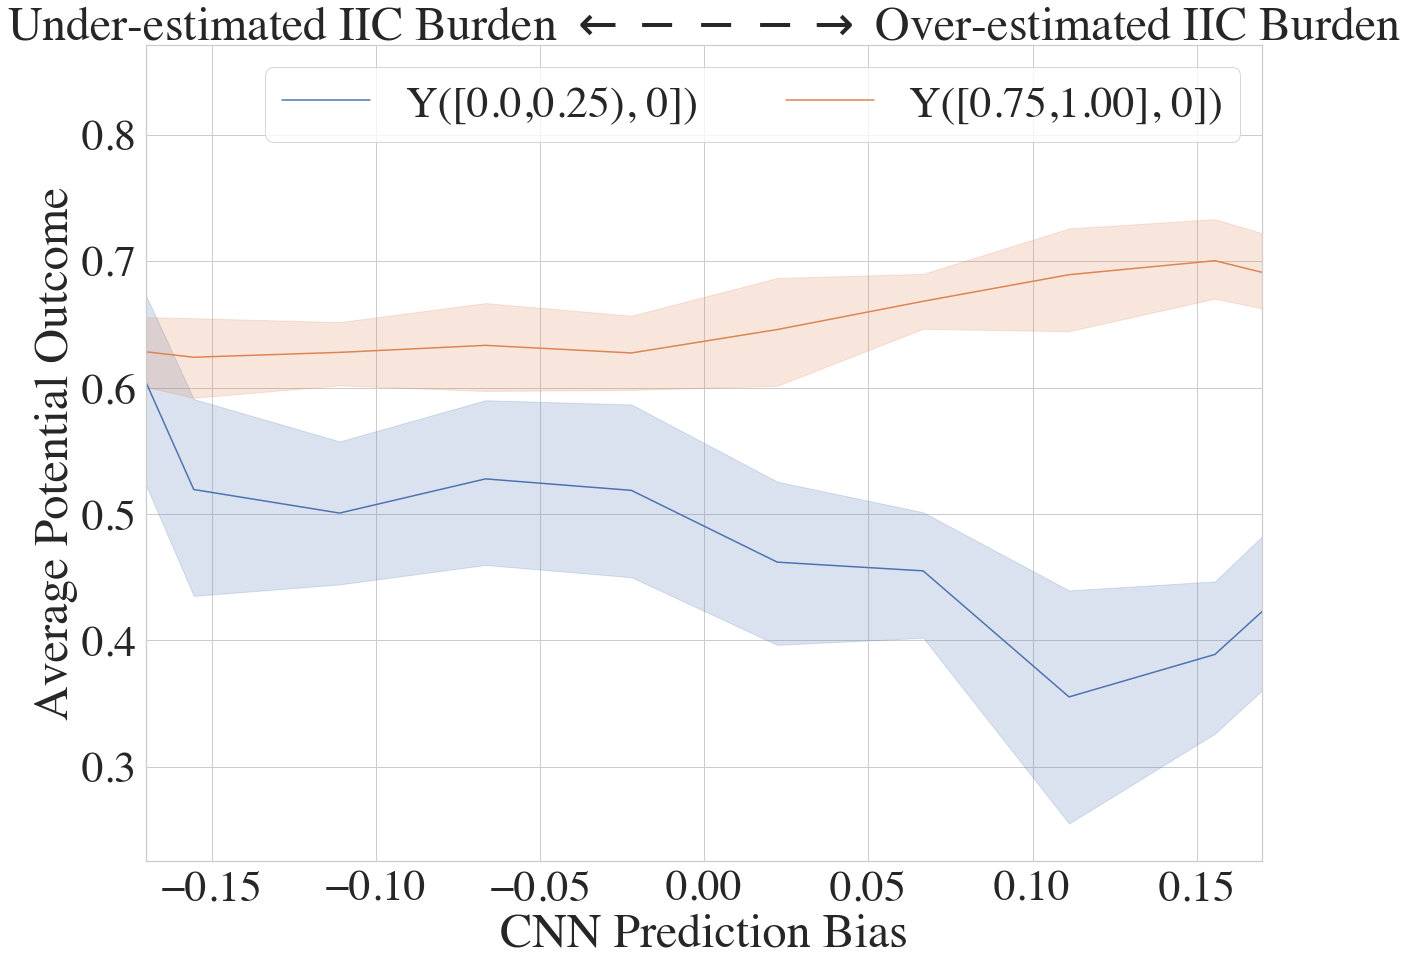

In [22]:
sns.set(font_scale=4,style='whitegrid')
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=False)

fig,ax = plt.subplots(figsize=(20,15))
sns.lineplot(x='Sensitivity Parameter',
             y='Average Potential Outcome',
             hue='index',
             data=apo_tight_0_c_pkpd_sens.loc[(apo_tight_0_c_pkpd_sens['index']=='Y((0.12, 0))') | (apo_tight_0_c_pkpd_sens['index']=='Y((0.88, 0))')].dropna().sort_values(by='index'))
plt.xlim((-0.17,0.17))
plt.legend(['Y([0.0,0.25), 0])','Y([0.75,1.00], 0])'],title=None, ncol=2)
plt.xlabel('CNN Prediction Bias')
plt.title(r'Under-estimated IIC Burden $\leftarrow --- \rightarrow$ Over-estimated IIC Burden' )
plt.savefig('sensitivity_bias_CNN.png')

# Unobserved confounder

$q(t,x) = E[Y_i(t) | T_i = t, X_i = x] - E[Y_i(t) | T_i = 1-t, X_i = x]$ \
$Y_{i,updated} = Y_i - q(T_i,X_i) (1 - Pr(T_i | X_i ))$

There is an unobserved confounder which is causing units with bad outcomes into treatment and units with good outcomes into control.
$q(t,x) = \psi (2t - 1)$

In [123]:
m_dict_dict = {}
cates_dict_dict = {}
df_dict_dict = {}
df_means_dict = {}
def q(t,psi):
    return psi*(np.log(0.1*t+1))   

#     Y_upd = ( ( Y_obs.values - ( q(df_malts['T'].values,problem) * 
#                                 ( df_malts['T'].values*(1 - prop_score_vals) + 
#                                  (1-df_malts['T'].values)*prop_score_vals ) ) ) >= 0.5 ).astype(int)


apo_tight_0_c_pkpd_unobs = pd.DataFrame()

iic_obs = (df_coarsen_1['E'])
iic_level = df_coarsen_1['E']>2
for threshold in thresholds:
    iic_level = iic_level + gain*(iic_obs>threshold).astype(int)

iic_level = iic_level - (gain/2) * ((iic_level - (gain/2)) > 0)

drug_level = ( (df_coarsen_1['levetiracetam'] > 20) + 
              (df_coarsen_1['propofol']>1) + 
              (df_coarsen_1['midazolam']>0) +
              (df_coarsen_1['lacosamide']>0) +
              (df_coarsen_1['pentobarbital']>0) +
              (df_coarsen_1['phenobarbital']>0) +
              (df_coarsen_1['valproate']>0) ).astype(int)

df_coarsen_1['iic'] = np.round(iic_level,2).astype(str)
df_coarsen_1['drug'] = drug_level
df_coarsen_1['T'] = '(' + df_coarsen_1['iic'].astype(str) + ', ' + df_coarsen_1['drug'].astype(str) + ')'

df_malts_data = df_coarsen_1[iic_burden['Cname']+list(df_pkpd.columns)+['Y','T']].loc[(df_coarsen_1['T']!='(0.0, 1)') & (df_coarsen_1['T']!='(0.0, 0)')]

prop_m = lm.LogisticRegressionCV(multi_class='multinomial')
treat_var_mapping = {'(0.12, 0)':0, '(0.38, 0)':1, '(0.62, 0)':2,'(0.88, 0)':3,'(0.12, 1)':4, '(0.38, 1)':5, '(0.62, 1)':6,'(0.88, 1)':7}
treat = np.array([ treat_var_mapping[i] for i in df_malts_data['T'].values ])
prop_m = prop_m.fit(X=df_malts_data[iic_burden['Cname']+list(df_pkpd.columns)],y=treat)
Y_obs = df_malts_data['Y'].values
prop_m_predict_proba = prop_m.predict_proba(X=df_malts_data[iic_burden['Cname']+list(df_pkpd.columns)])
prop_score_obs_treat = np.array([prop_m_predict_proba[i,treat[i]] for i in range(len(treat))])

for psi in tqdm.tqdm(np.linspace(start=-1, stop=1, num=11)):
    Y_upd = ((Y_obs - q(df_coarsen_1['E'].loc[df_malts_data.index].values,psi)*(1-prop_score_obs_treat)))
    Y_upd = Y_upd*(Y_upd>0)
    Y_upd = Y_upd * (Y_upd <= 1) + (Y_upd > 1)
    
    df_malts_data['Y_upd'] = Y_upd
    n_repeats = 5
    n_splits = 3
    
    discrete = list(set(iic_burden['Cname']).difference(continuous))
    m = pm.malts_mf(outcome='Y_upd',
                    treatment='T', 
                    data=df_malts_data.drop(columns=['Y']),
                    n_repeats=n_repeats,
                    n_splits=n_splits,
                    output_format='full',
                    k_tr=3,
                    k_est=5,
                    discrete = discrete,
                    C=0.01)
    
    out = m.CATE_df.drop(columns = ['Y_upd','T'])#.T.groupby(level=0).mean().T
    
    columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1) 
               if 'Y(('+str(np.round(threshold-gain/2,2))+', 0))' in out.columns ]
    apo_0_c_pkpd = out[columns]
    
    columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1) 
               if 'Y(('+str(np.round(threshold-gain/2,2))+', 0))' in out.columns ]
    diam_0_c_pkpd = out[columns]

    apo_tight_0_c_pkpd = pd.DataFrame(apo_0_c_pkpd.values*(diam_0_c_pkpd<2000).astype(int).replace(0, np.nan).values,
                             index=apo_0_c_pkpd.index,columns=apo_0_c_pkpd.columns)
    apo_tight_0_c_pkpd.mean(axis=0)

    pd_temp = apo_tight_0_c_pkpd.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'})
    pd_temp['Sensitivity Parameter'] = np.ones((pd_temp.shape[0],)) * psi
    
    apo_tight_0_c_pkpd_unobs = apo_tight_0_c_pkpd_unobs.append(pd_temp,ignore_index=True)
    apo_tight_0_c_pkpd_unobs.to_csv('unobs_conf_sens.csv')

100%|██████████| 11/11 [1:05:38<00:00, 358.07s/it]


In [23]:
apo_tight_0_c_pkpd_unobs = pd.read_csv('unobs_conf_sens.csv',index_col=0)

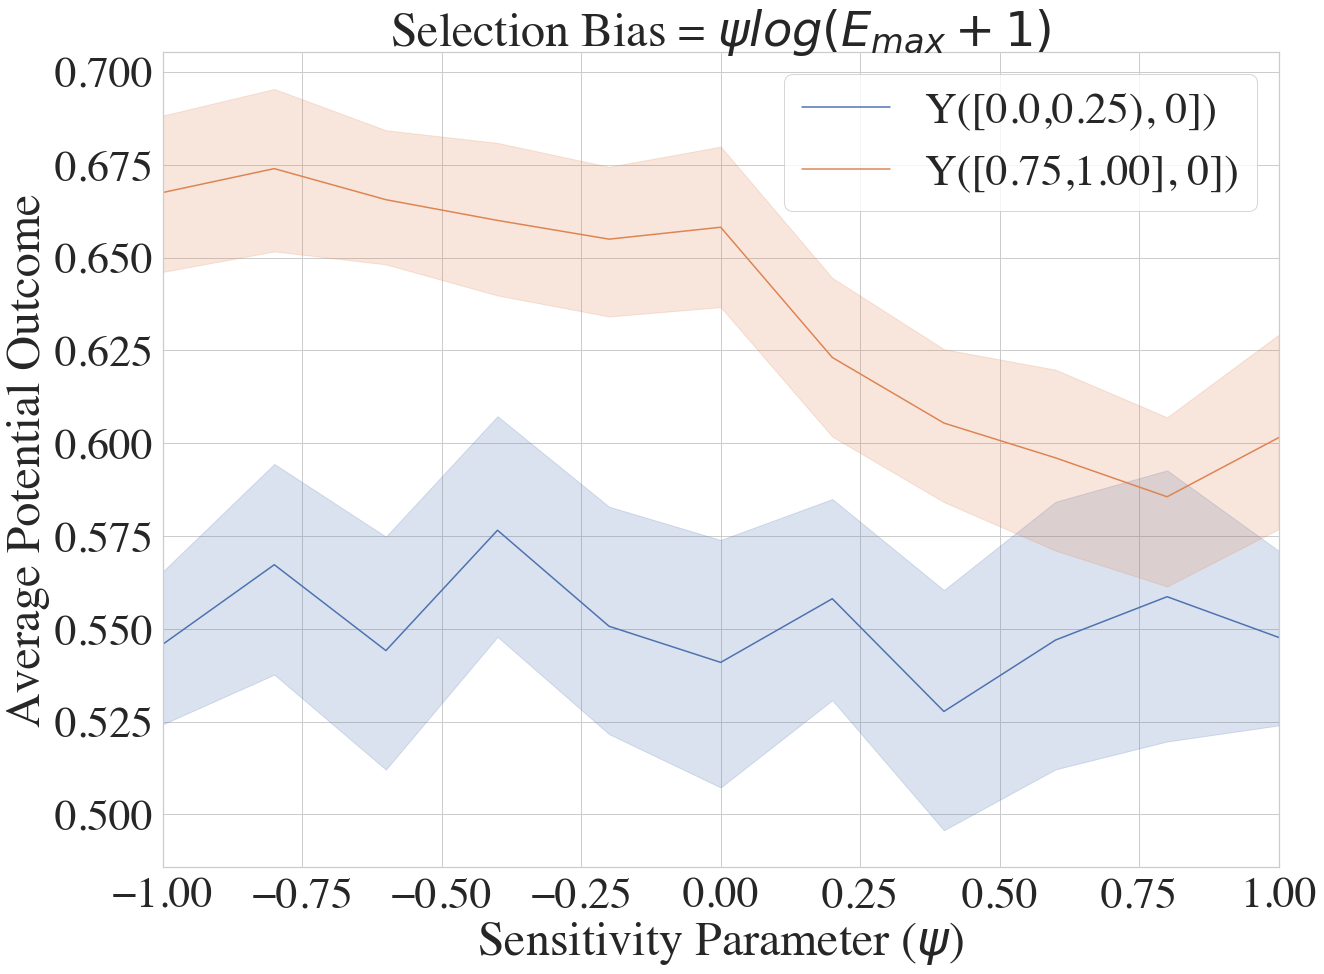

In [27]:
sns.set(font_scale=4,style='whitegrid')
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=False)

fig,ax = plt.subplots(figsize=(20,15))
sns.lineplot(x='Sensitivity Parameter',
             y='Average Potential Outcome',
             hue='index',
             data=apo_tight_0_c_pkpd_unobs.loc[(apo_tight_0_c_pkpd_unobs['index']=='Y((0.12, 0))') | (apo_tight_0_c_pkpd_unobs['index']=='Y((0.88, 0))')].dropna().sort_values(by='index'),
             ci=70)
plt.xlim((-1,1))
plt.legend(['Y([0.0,0.25), 0])','Y([0.75,1.00], 0])'],title='')
plt.xlabel('Sensitivity Parameter ($\psi$)')
plt.title('Selection Bias = $\psi log(E_{max}+1)$')
plt.savefig('sensitivity_bias_selection.png')

In [ ]:
fig = plt.figure(figsize=(20,12))
sns.lineplot(x='sensitivity parameter',y='(0.10,0.45]',data=ates,ci="sd")
sns.lineplot(x='sensitivity parameter',y='(0.45,0.80]',data=ates,ci="sd")
sns.lineplot(x='sensitivity parameter',y='(0.80,1.00]',data=ates,ci="sd")
plt.legend(['(0.10,0.45]','(0.45,0.80]','(0.80,1.00]'],loc='upper right')
plt.ylabel('Estimated ATE')
plt.xlim((0,1))
plt.axvline(0.69,c='red',ls='--')
fig.savefig('unobs_conf_max_c.png')

In [111]:
np.linspace(start=-1, stop=1, num=17)

array([-1.   , -0.875, -0.75 , -0.625, -0.5  , -0.375, -0.25 , -0.125,
        0.   ,  0.125,  0.25 ,  0.375,  0.5  ,  0.625,  0.75 ,  0.875,
        1.   ])